In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import nltk
from nltk.stem import PorterStemmer
import re

import warnings
warnings.filterwarnings('ignore')

from transformers import AutoTokenizer, TFBertModel

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df_train = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df_test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
df_train = df_train.drop(['keyword', 'location'], axis=1)
df_test = df_test.drop(['keyword', 'location'], axis=1)

In [3]:
def preprocess_text(df, col):
    porter = PorterStemmer()
    df[col] = df[col].apply(lambda x: x.lower()) ## lowercase
    df[col] = df[col].apply(lambda x: " ".join([porter.stem(word) for word in x.split()])) ## stem
    df[col] = df[col].apply(lambda x: " ".join(["" if '@' in word else word for word in x.split()])) ## remove taggings
    df[col] = df[col].apply(lambda x: " ".join(["" if '#' in word else word for word in x.split()])) ## remove hashtags
    df[col] = df[col].apply(lambda x: "".join(["" if ch.isdigit() and ch != ' ' else ch for ch in x])) ## remove digits
    df[col] = df[col].apply(lambda x: "".join([ch if ch.isalnum() or ch == ' ' else '' for ch in x])) ## remove special chars  

In [4]:
preprocess_text(df_train, 'text')
df_train.head()

,id,text,target
0,1,our deed are the reason of thi may allah forg...,1
1,4,forest fire near la rong sask canada,1
2,5,all resid ask to shelter in place are be notif...,1
3,6,peopl receiv evacu order in california,1
4,7,just got sent thi photo from rubi as smoke fr...,1


In [5]:
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [6]:
max_len = max(df_train['text'].apply(lambda x: len(x.split())))
max_len

31

In [7]:
X_train = tokenizer(
    text = df_train.text.tolist(),
    add_special_tokens = True,
    max_length = max_len,
    truncation = True,
    padding = True,
    return_tensors = 'tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True
)
y_train = df_train.target.values

In [8]:
print(X_train.input_ids.shape)
print(y_train.shape)

(7613, 31)
(7613,)


In [9]:
def get_model(max_len, trainable):
    input_ids = keras.layers.Input(shape=(max_len,), dtype=tf.int32, name='input_ids')
    input_mask = keras.layers.Input(shape=(max_len,),dtype=tf.int32, name='attention_mask')
    embeddings = bert([input_ids, input_mask])[1]
    out = keras.layers.Dropout(0.2)(embeddings)
    out = keras.layers.Dense(128, activation='relu')(out)
    out = keras.layers.Dropout(0.2)(out)
    out = keras.layers.Dense(32, activation='relu')(out)
    out = keras.layers.Dropout(0.2)(out)
    out = keras.layers.Dense(1, activation='sigmoid')(out)
    model = keras.Model(inputs=[input_ids,input_mask], outputs=out)
    model.layers[2].trainable = trainable
    return model

In [10]:
model = get_model(max_len,True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 31)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 31)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  335141888   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 31,                                            

In [11]:
optimizer = keras.optimizers.Adam(
    learning_rate = 5e-6,
    epsilon = 1e-08,
    clipnorm = 1.0)

loss = keras.losses.BinaryCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics = ['accuracy'])

In [12]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
train_history = model.fit(
    x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
    y = y_train,
    validation_split = 0.2,
    epochs = 10,
    batch_size = 32
)

Epoch 1/10
191/191 [==============================] - 206s 564ms/step - loss: 0.6737 - accuracy: 0.5888 - val_loss: 0.5116 - val_accuracy: 0.7682
Epoch 2/10
191/191 [==============================] - 97s 508ms/step - loss: 0.5103 - accuracy: 0.7703 - val_loss: 0.4334 - val_accuracy: 0.8122
Epoch 3/10
191/191 [==============================] - 95s 500ms/step - loss: 0.4353 - accuracy: 0.8238 - val_loss: 0.4257 - val_accuracy: 0.8102
Epoch 4/10
191/191 [==============================] - 95s 500ms/step - loss: 0.3797 - accuracy: 0.8585 - val_loss: 0.4440 - val_accuracy: 0.8155
Epoch 5/10
191/191 [==============================] - 95s 500ms/step - loss: 0.3386 - accuracy: 0.8757 - val_loss: 0.4686 - val_accuracy: 0.8188
Epoch 6/10
191/191 [==============================] - 95s 498ms/step - loss: 0.2888 - accuracy: 0.8984 - val_loss: 0.4800 - val_accuracy: 0.8076
Epoch 7/10
191/191 [==============================] - 92s 482ms/step - loss: 0.2422 - accuracy: 0.9194 - val_loss: 0.4839 - val_a

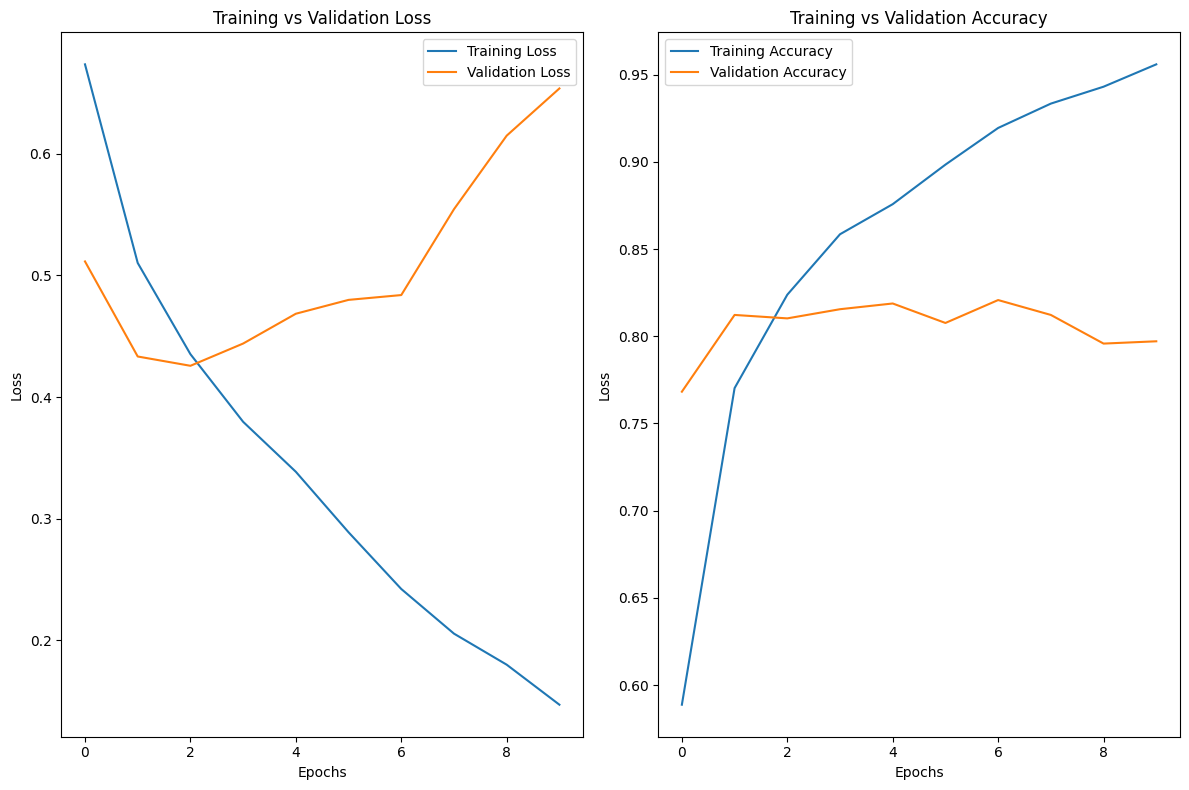

In [14]:
fig, axes = plt.subplots(1,2, figsize=(12,8))
axes = axes.flatten()
axes[0].plot(train_history.history['loss'])
axes[0].plot(train_history.history['val_loss'])
axes[0].set_title('Training vs Validation Loss')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training Loss', 'Validation Loss'])

axes[1].plot(train_history.history['accuracy'])
axes[1].plot(train_history.history['val_accuracy'])
axes[1].set_title('Training vs Validation Accuracy')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training Accuracy', 'Validation Accuracy'])

plt.tight_layout()
plt.show()